# Notebook de test


## Importation des bibliothèques


In [1]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt


import spacy
import random
import math
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor

## Fonctions utiles

In [2]:
def progress_bar(iteration, total, prefix='', suffix='', decimals=1, length=50, fill='█'):
    """Fonction d'affichage de progress bar, récupérée sur le Notebook du TD1 de Data Sciences de Myriam Tami
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = fill * filled_length + '-' * (length - filled_length)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end='\r')
    # Print New Line on Complete
    if iteration == total:
        print()
                
def raw_to_tokens(raw_string, spacy_nlp):
        # Write code for lower-casing
    string = raw_string.lower()

    # Write code to normalize the accents
    string = normalize_accent(string)

    # Write code to tokenize
    spacy_tokens = spacy_nlp(string)
    

    # Write code to remove punctuation tokens and create string tokens
    string_tokens = [token.orth_ for token in spacy_tokens if not token.is_punct if not token.is_stop]
    # Write code to join the tokens back into a single string
    clean_string = " ".join(string_tokens)

    return clean_string


def normalize_accent(string):
    string = string.replace('á', 'a')
    string = string.replace('â', 'a')
    string = string.replace('à', 'a')
    
    string = string.replace('é', 'e')
    string = string.replace('è', 'e')
    string = string.replace('ê', 'e')
    string = string.replace('ë', 'e')

    string = string.replace('î', 'i')
    string = string.replace('ï', 'i')
    string = string.replace('n°','n')
    string = string.replace('ö', 'o')
    string = string.replace('ô', 'o')
    string = string.replace('ò', 'o')
    string = string.replace('ó', 'o')

    string = string.replace('ù', 'u')
    string = string.replace('û', 'u')
    string = string.replace('ü', 'u')

    string = string.replace('ç', 'c')

    return string

## Récupération des données

récupération du dico français

In [40]:
spacy_nlp = spacy.load("fr_core_news_sm")

récupération des vecteurs x_data et y_data

In [70]:
Reload = False
filename = "X_dt.mat"
subdata_ratio  = 1


if not Reload:
    X_data = scipy.io.loadmat('.\data\\' + filename)['data']
else:
    Xtrain_filename = ".\data\X_train_update.csv"   
    #pour le x_data (ici la designation, ie string)
    X_data = []
    raw_data = pd.read_csv(Xtrain_filename,index_col=0)
    design = raw_data['designation']
    #la boucle suivante prend bcp de temps
    for k in range(len(raw_data)//subdata_ratio):
        X_data.append(raw_to_tokens(design[k],spacy_nlp))
        progress_bar(k + 1,len(raw_data)//subdata_ratio, prefix='Preprocessing train:', suffix='Complété', length=50)
            
Y_train_filename = ".\data\Y_train_CVw08PX.csv"
#pour y_data (le product type id)
y_data = pd.read_csv(Y_train_filename,index_col=0)[:len(X_data)//subdata_ratio] #récupération de la bonne colonne prdtypecode


Enregistrement de X_data en mémoire pour éviter de le reload à chaque fois

In [7]:
mdic = {"data": X_data}
scipy.io.savemat('.\data\\' + filename,mdic)

On affiche le head du fichier

In [63]:
print(raw_data['designation'])



84916    Folkmanis Puppets - 2732 - Marionnette Et Théâ...
84917    Porte Flamme Gaxix - Flamebringer Gaxix - 136/...
84918                    Pompe de filtration Speck Badu 95
84919                          Robot de piscine électrique
84920    Hsm Destructeur Securio C16 Coupe Crois¿E: 4 X...
                               ...                        
98723    Robe De Soutien De Sac De Soins De Les Suspend...
98724            Livre De Phrases - Français ? Thaïlandais
98725                 Tifon1 200 M de Espa - Pompe piscine
98726    Christmas Home Non Slip Door Floor Mats Hall R...
98727    Suspension Cascade 6 Lumières Verra Noire Et C...
Name: designation, Length: 13812, dtype: object


In [9]:
y_data.head()
set(y_data['prdtypecode'].tolist())

{10,
 40,
 50,
 60,
 1140,
 1160,
 1180,
 1280,
 1281,
 1300,
 1301,
 1302,
 1320,
 1560,
 1920,
 1940,
 2060,
 2220,
 2280,
 2403,
 2462,
 2522,
 2582,
 2583,
 2585,
 2705,
 2905}

On affiche l'histogramme du type de produit sur tout le jeu de données

In [3]:
%pip install unidecode

   ---------------------------------------- 0.0/235.5 kB ? eta -:--:--
   ------ -------------------------------- 41.0/235.5 kB 991.0 kB/s eta 0:00:01
   --------------- ------------------------ 92.2/235.5 kB 1.1 MB/s eta 0:00:01
   --------------------------------- ------ 194.6/235.5 kB 1.5 MB/s eta 0:00:01
   -------------------------------------- - 225.3/235.5 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 235.5/235.5 kB 1.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


<AxesSubplot: xlabel='Count', ylabel='Code_produit'>

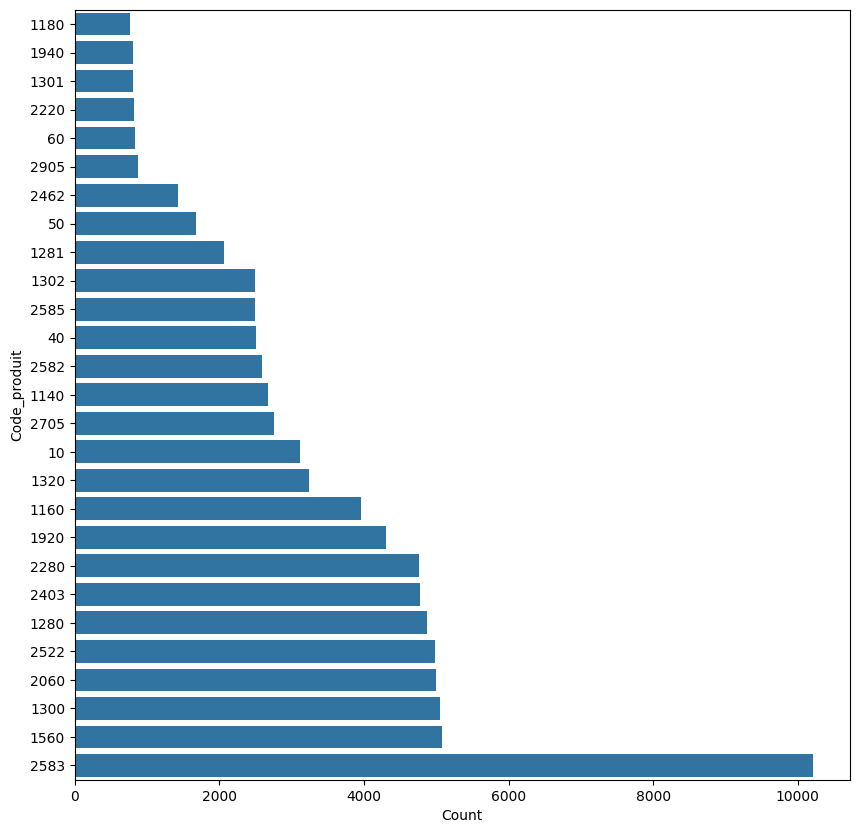

In [10]:
hist_tab_y = pd.DataFrame(y_data.prdtypecode.value_counts()).reset_index()
hist_tab_y.columns = ['Code_produit', 'Count']
hist_y = hist_tab_y.sort_values("Count", ascending=True)
plt.figure(figsize=(10,10))
sns.barplot(x='Count', y='Code_produit', data=hist_y, orient='h', order=hist_y.Code_produit.tolist())


Une approche ici serait de repérer le vocabulaire endémique à chaque product type pour déterminer, en fonction de la désignation du produit, son type.

In [11]:
tfidf = TfidfVectorizer()

# Write code to vectorize the sample text
X_tfidf_matrix = tfidf.fit_transform(X_data)

print("Shape of the TF-IDF Matrix:")
print(X_tfidf_matrix.shape)
print("TF-IDF Matrix:")



Shape of the TF-IDF Matrix:
(84916, 79882)
TF-IDF Matrix:


Split du jeu de données

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_matrix, y_data, test_size=0.2, random_state=42)

# Méthode 1 : K-NN Classifier

In [13]:
KNN_CL = False
if KNN_CL:
    params = {'n_neighbors':range(2,20)}
    n_folds = 10
    cv = KFold(n_splits=n_folds, shuffle=False)

    grid_search = GridSearchCV(
        estimator=KNeighborsClassifier(),
        param_grid=params,
        return_train_score=True,
        cv=cv,
        ).fit(X_train, y_train)


In [14]:
grid_search.best_estimator_

NameError: name 'grid_search' is not defined

In [ ]:
BestKNN = KNeighborsClassifier(n_neighbors=19).fit(X_train,y_train)

y_predKNN = BestKNN.predict(X_test)

F1_score = f1_score(y_test,y_predKNN,average='macro')
print(F1_score)

0.44928423513714305


## Approche 2 : SVM

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score

X_tfidf = X_tfidf_matrix

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)


svm_model = SVC(kernel='linear', probability=True) 
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print("Classification Report:\n", classification_report(y_test, y_pred))


In [1]:
%pip install nltk

     ---------------------------------------- 0.0/42.0 kB ? eta -:--:--
     -------------------------------------- 42.0/42.0 kB 675.2 kB/s eta 0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   --- ------------------------------------ 0.1/1.5 MB 3.5 MB/s eta 0:00:01
   ------- -------------------------------- 0.3/1.5 MB 3.5 MB/s eta 0:00:01
   -------- ------------------------------- 0.3/1.5 MB 2.6 MB/s eta 0:00:01
   ---------------- ----------------------- 0.6/1.5 MB 3.6 MB/s eta 0:00:01
   ----------------- ---------------------- 0.7/1.5 MB 3.8 MB/s eta 0:00:01
   ----------------------- ---------------- 0.9/1.5 MB 3.7 MB/s eta 0:00:01
   ------------------------------ --------- 1.2/1.5 MB 3.7 MB/s eta 0:00:01
   ---------------------------------- ----- 1.3/1.5 MB 3.6 MB/s eta 0:00:01
   ---------------------------------------  1.5/1.5 MB 3.6 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 3.6 MB/s eta 0:00:00
   ----------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


## Approche 3 : Deep Learning s1

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

In [84]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K

# Supposons que X_tfidf_matrix et y_data soient déjà définis
X_tfidf = X_tfidf_matrix

# Encodage des labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_data)

# Conversion des labels en une représentation catégorielle
y_categorical = to_categorical(y_encoded)

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_categorical, test_size=0.2, random_state=42)

# Création d'un générateur personnalisé
class SparseMatrixBatchGenerator(Sequence):
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(self.X.shape[0] / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.X[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x.toarray(), batch_y

# Définir la fonction personnalisée pour le F1 score
def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    f1 = 2 * ((precision_value * recall_value) / (precision_value + recall_value + K.epsilon()))
    return f1

# Définir et compiler le modèle
input_dim = X_train.shape[1]
num_classes = y_categorical.shape[1]

model = Sequential()
model.add(Dense(1024, input_dim=input_dim, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[f1_score])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_f1_score', mode='max', save_best_only=True, verbose=1)

# Entraîner le modèle en utilisant le générateur
batch_size = 32
train_generator = SparseMatrixBatchGenerator(X_train, y_train, batch_size)
val_generator = SparseMatrixBatchGenerator(X_test, y_test, batch_size)

history = model.fit(train_generator,
                    epochs=6, 
                    validation_data=val_generator,
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])

# Charger le meilleur modèle
model.load_weights('best_model.keras')

# Évaluation du modèle
loss, f1 = model.evaluate(val_generator)
print(f'Test Loss: {loss}')
print(f'Test F1 Score: {f1}')


c:\Users\chata\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\chata\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6


c:\Users\chata\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2123/2123 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - f1_score: 0.5338 - loss: 1.8257
Epoch 1: val_f1_score improved from -inf to 0.78696, saving model to best_model.keras
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 1029s 483ms/step - f1_score: 0.5339 - loss: 1.8254 - val_f1_score: 0.7870 - val_loss: 0.7410 - learning_rate: 0.0010
Epoch 2/6
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - f1_score: 0.8486 - loss: 0.5179
Epoch 2: val_f1_score improved from 0.78696 to 0.79538, saving model to best_model.keras
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 1021s 481ms/step - f1_score: 0.8486 - loss: 0.5179 - val_f1_score: 0.7954 - val_loss: 0.7624 - learning_rate: 0.0010
Epoch 3/6
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - f1_score: 0.9238 - loss: 0.2536
Epoch 3: val_f1_score did not improve from 0.79538
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 1016s 479ms/step - f1_score: 0.9238 - loss: 0.2536 - val_f1_score: 0.7919 - val_loss: 0.8924 - learning_rate: 0.0010
Epoch 4/6
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - f1_score: 0.9507

In [99]:
Reload = True
filename = "X_dt.mat"
subdata_ratio  = 1


if not Reload:
    X_data_test = scipy.io.loadmat('.\data\\' + filename)['data']
else:
    Xtest_filename = ".\data\X_test_update.csv"   
    #pour le x_data (ici la designation, ie string)
    X_data_test = []
    raw_data_test = pd.read_csv(Xtest_filename,index_col=0)
    design_test = raw_data_test['designation']
    #la boucle suivante prend bcp de temps
    for k in range(len(raw_data_test)//subdata_ratio):
        X_data_test.append(raw_to_tokens(design_test[len(X_data)+k],spacy_nlp))
        progress_bar(k + 1,len(raw_data_test)//subdata_ratio, prefix='Preprocessing train:', suffix='Complété', length=50)
           


Preprocessing train: |██████████████████████████████████████████████████| 100.0% Complété


v1 à 79.17%

In [115]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from tensorflow.keras import backend as K

# Supposons que X_data, y_data et X_data_test soient déjà définis

# Création du transformateur TFIDF et transformation des données
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X_data)
X_tfidf_test = tfidf_vectorizer.transform(X_data_test)

# Encodage des labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_data)

# Conversion des labels en une représentation catégorielle
y_categorical = to_categorical(y_encoded)

# Division des données en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y_categorical, test_size=0.2, random_state=42)

# Création d'un générateur personnalisé
class SparseMatrixBatchGenerator(Sequence):
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(self.X.shape[0] / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.X[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x.toarray(), batch_y

# Création d'un générateur pour la prédiction
class SparseMatrixPredictionGenerator(Sequence):
    def __init__(self, X, batch_size):
        self.X = X
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(self.X.shape[0] / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.X[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x.toarray()

# Définir la fonction personnalisée pour le F1 score
def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    f1 = 2 * ((precision_value * recall_value) / (precision_value + recall_value + K.epsilon()))
    return f1

# Définir et compiler le modèle avec moins de couches
input_dim = X_train.shape[1]
num_classes = y_categorical.shape[1]

model = Sequential()
model.add(Dense(128, input_dim=input_dim, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[f1_score])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_f1_score', mode='max', save_best_only=True, verbose=1)

# Entraîner le modèle en utilisant le générateur
batch_size = 32
train_generator = SparseMatrixBatchGenerator(X_train, y_train, batch_size)
val_generator = SparseMatrixBatchGenerator(X_val, y_val, batch_size)

history = model.fit(train_generator,
                    epochs=5, 
                    validation_data=val_generator,
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])

# Charger le meilleur modèle
model.load_weights('best_model.keras')

# Prédiction sur les nouvelles données de test en utilisant le générateur
test_generator = SparseMatrixPredictionGenerator(X_tfidf_test, batch_size)
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Décoder les prédictions en labels originaux
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Afficher les résultats
print("Prédictions sur le dataset de test:", y_pred_labels)


Epoch 1/5


c:\Users\chata\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\chata\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


   2/2123 ━━━━━━━━━━━━━━━━━━━━ 2:27 70ms/step - f1_score: 0.0405 - loss: 4.5112

c:\Users\chata\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2123/2123 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - f1_score: 0.4274 - loss: 2.0025
Epoch 1: val_f1_score improved from -inf to 0.76946, saving model to best_model.keras
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 148s 69ms/step - f1_score: 0.4274 - loss: 2.0023 - val_f1_score: 0.7695 - val_loss: 0.7765 - learning_rate: 0.0010
Epoch 2/5
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - f1_score: 0.7620 - loss: 0.7831
Epoch 2: val_f1_score improved from 0.76946 to 0.79765, saving model to best_model.keras
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 148s 70ms/step - f1_score: 0.7620 - loss: 0.7831 - val_f1_score: 0.7977 - val_loss: 0.7153 - learning_rate: 0.0010
Epoch 3/5
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - f1_score: 0.8474 - loss: 0.4982
Epoch 3: val_f1_score improved from 0.79765 to 0.80193, saving model to best_model.keras
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 150s 70ms/step - f1_score: 0.8474 - loss: 0.4982 - val_f1_score: 0.8019 - val_loss: 0.7598 - learning_rate: 0.0010
Epoch 4/5
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 0s 

V2

Epoch 1/5


c:\Users\chata\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\chata\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\chata\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit

2123/2123 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - f1_score: 0.5505 - loss: 1.6460
Epoch 1: val_f1_score improved from -inf to 0.78836, saving model to best_model.keras
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 533s 250ms/step - f1_score: 0.5506 - loss: 1.6458 - val_f1_score: 0.7884 - val_loss: 0.7305 - learning_rate: 0.0010
Epoch 2/5
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - f1_score: 0.8590 - loss: 0.4801
Epoch 2: val_f1_score improved from 0.78836 to 0.79667, saving model to best_model.keras
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 531s 250ms/step - f1_score: 0.8590 - loss: 0.4801 - val_f1_score: 0.7967 - val_loss: 0.7837 - learning_rate: 0.0010
Epoch 3/5
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - f1_score: 0.9332 - loss: 0.2267
Epoch 3: val_f1_score did not improve from 0.79667
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 527s 248ms/step - f1_score: 0.9332 - loss: 0.2267 - val_f1_score: 0.7896 - val_loss: 0.9111 - learning_rate: 0.0010
Epoch 4/5
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - f1_score: 0.9568 - 

In [106]:
print(len(y_pred_labels),len(X_data_test))


13812 13812


In [120]:
import csv

filename = 'output1.csv'
# Écriture de la liste dans le fichier CSV
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file, lineterminator='\n')
    writer.writerow(['','prdtypecode'])
    k=0
    for value in y_pred_labels:
        writer.writerow([len(X_data)+k,value])
        k+=1

531/531 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.47      0.48       612
           1       0.71      0.63      0.67       521
           2       0.81      0.80      0.80       357
           3       0.94      0.81      0.87       161
           4       0.72      0.76      0.74       539
           5       0.91      0.93      0.92       786
           6       0.61      0.62      0.62       146
           7       0.64      0.65      0.65       961
           8       0.58      0.39      0.47       424
           9       0.92      0.94      0.93       974
          10       0.94      0.91      0.92       169
          11       0.84      0.74      0.79       507
          12       0.77      0.75      0.76       672
          13       0.85      0.80      0.82      1013
          14       0.86      0.93      0.89       841
          15       0.80      0.83      0.82       137
          16  

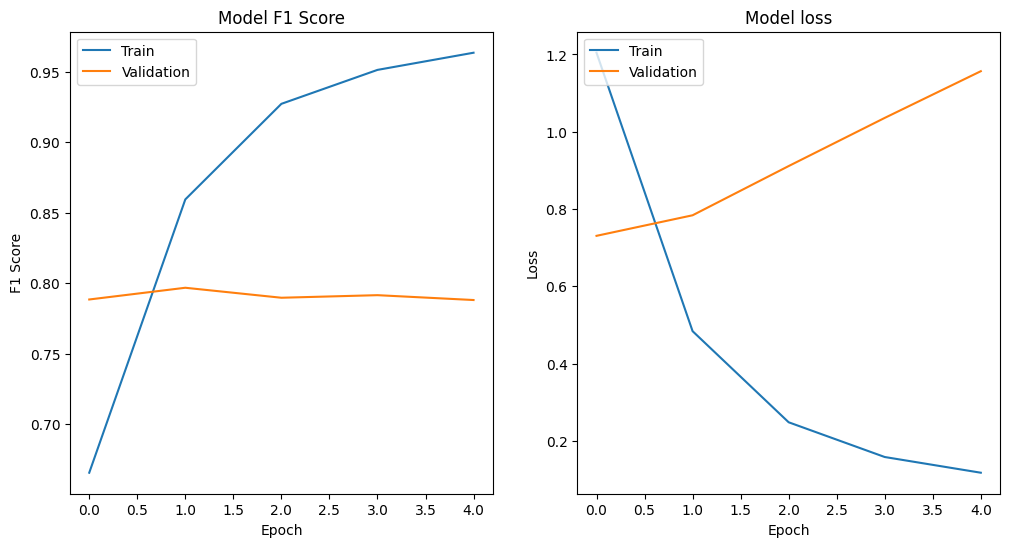

In [122]:

# Prédiction sur l'ensemble de test
y_pred_prob = model.predict(val_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_true = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_test_true, y_pred))

# Visualiser les résultats
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()



In [27]:
print(y_pred)


[26  5 16 ... 24 21 14]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Chargement des données
df = pd.read_csv('votre_fichier.csv')

# Extraction des features et des labels
X_data = df['designation']
y_data = df['identifiant_produit']

# Vectorisation TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X_data)

# Encodage des labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_data)

# Conversion des labels en une représentation catégorielle
y_categorical = to_categorical(y_encoded)

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_categorical, test_size=0.2, random_state=42)

# Définir et compiler le modèle
input_dim = X_train.shape[1]
num_classes = y_categorical.shape[1]

model = Sequential()
model.add(Dense(1024, input_dim=input_dim, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

# Entraîner le modèle
history = model.fit(X_train.toarray(), y_train,
                    epochs=50, 
                    batch_size=32, 
                    validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr])

# Évaluation du modèle
loss, accuracy = model.evaluate(X_test.toarray(), y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

y_pred_prob = model.predict(X_test.toarray())
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_true = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_test_true, y_pred))

# Visualiser les résultats
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


c:\Users\chata\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\chata\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Shape of y_categorical: (84916, 27)
Shape of X_train: (67932, 79882)
Shape of y_train: (67932, 27)
Shape of X_test: (16984, 79882)
Shape of y_test: (16984, 27)


MemoryError: Unable to allocate 40.4 GiB for an array with shape (67932, 79882) and data type float64

In [ ]:
print(f1_score(y_test_true,y_pred,average='macro'))

0.7018172599405393
